# Black-Scholes-Barenblatt

Consider the system \begin{array}{l}
dX_t = \sigma\text{diag}(X_t)dW_t, ~~~ t \in [0,T],\\
X_0 = \xi,\\
dY_t = r(Y_t - Z_t' X_t)dt + \sigma Z_t'\text{diag}(X_t)dW_t, ~~~ t \in [0,T),\\
Y_T = g(X_T),
\end{array}
where $T=1$, $\sigma = 0.4$, $r=0.05$, $\xi = (1,0.5,1,0.5,\ldots,1,0.5) \in \mathbb{R}^{2}$, and $g(x) = \Vert x \Vert ^2$.

The above equations are related to the Black-Scholes-Barenblatt equation
\begin{equation}
u_t = -\frac{1}{2} \text{Tr}[\sigma^2 \text{diag}(X_t^2) D^2u] + r(u - (Du)' x),
\end{equation}
with terminal condition $u(T,x) = g(x)$ via
\begin{equation}
Y_t = u(t, X_t)\qquad , \qquad Z_t = Du(t, X_t).
\end{equation}

 The Black-Scholes-Barenblatt equation admits the explicit solution
\begin{equation}
u(t,x) = \exp \left( (r + \sigma^2) (T-t) \right)g(x).
\end{equation}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time

def phi_tf(t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        return 0.05*(Y - tf.reduce_sum(X*Z, 1, keepdims = True)) # M x 1

def g_tf(X): # M x D
    return tf.reduce_sum(X**2, 1, keepdims = True) # M x 1

def sigma_tf(t, X, Y): # M x 1, M x D, M x 1
    return 0.4*tf.linalg.diag(X) # M x D x D

def mu_tf(t, X, Y, Z): # M x 1, M x D, M x 1, M x D
  return np.zeros([M,D]) # M x D


def net_u(model, t, X): # M x 1, M x D
  with tf.GradientTape() as tape:
    tape.watch(X)
    u = model(tf.concat([t,X], 1)) # M x 1
  Du = tape.gradient(u, X) # M x D
  return u, Du

def Dg_tf(X): # M x D
  with tf.GradientTape() as tape:
    tape.watch(X)
    g_tf_X = g_tf(X)
  return tape.gradient(g_tf_X, X) # M x D

def loss_function(model, t, W, Xi): # M x (N+1) x 1, M x (N+1) x D, 1 x D
  loss = 0
  X_list = []
  Y_list = []

  t0 = t[:,0,:]
  W0 = W[:,0,:]
  X0 = tf.tile(Xi,[M,1]) # M x D
  Y0, Z0 = net_u(model, t0,X0) # M x 1, M x D

  X_list.append(X0)
  Y_list.append(Y0)

  for n in range(0, N):
    t1 = t[:,n+1,:]
    W1 = W[:,n+1,:]
    X1 = X0 + mu_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.squeeze(tf.matmul(sigma_tf(t0,X0,Y0), tf.expand_dims(W1-W0,-1)), axis=[-1])
    Y1_tilde = Y0 + phi_tf(t0,X0,Y0,Z0)*(t1-t0)
    Y1_tilde += tf.reduce_sum(Z0*tf.squeeze(tf.matmul(sigma_tf(t0,X0,Y0),tf.expand_dims(W1-W0,-1))), axis=1, keepdims = True)
    Y1, Z1 = net_u(model, t1, X1)

    loss += tf.reduce_sum(tf.square(Y1 - Y1_tilde))

    t0 = t1
    W0 = W1
    X0 = X1
    Y0 = Y1
    Z0 = Z1

    X_list.append(X0)
    Y_list.append(Y0)

  loss += tf.reduce_sum(tf.square(Y1 - g_tf(X1)))
  loss += tf.reduce_sum(tf.square(Z1 - Dg_tf(X1)))

  X = tf.stack(X_list,axis=1)
  Y = tf.stack(Y_list,axis=1)

  return loss, X, Y, Y[0,0,0]

def fetch_minibatch():
  Dt = np.zeros((M,N+1,1), dtype=np.float32) # M x (N+1) x 1
  DW = np.zeros((M,N+1,D), dtype=np.float32) # M x (N+1) x D

  dt = T/N

  Dt[:,1:,:] = dt
  DW[:,1:,:] = np.sqrt(dt)*np.random.normal(size=(M,N,D)).astype(np.float32)

  t = np.cumsum(Dt,axis=1) # M x (N+1) x 1
  W = np.cumsum(DW,axis=1) # M x (N+1) x D

  return t, W

def train(model, N_Iter, learning_rate):
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  start_time = time.time()
  for it in range(N_Iter):

    t_batch, W_batch = fetch_minibatch() # M x (N+1) x 1, M x (N+1) x D

    with tf.GradientTape() as tape:
      loss, _, _, _ = loss_function(model, t_batch, W_batch, Xi)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Print
    if it % 100 == 0:
      elapsed = time.time() - start_time
      print('It: %d, Loss: %.3e, Time: %.2f, Learning Rate: %.3e' % (it, loss, elapsed, learning_rate))
      start_time = time.time()


def predict(model, Xi_star, t_star, W_star):
  _, X_star, Y_star, _ = loss_function(model, t_star, W_star, Xi_star)
  return X_star, Y_star

In [ ]:
M = 100 # number of trajectories (batch size)
N = 50 # number of time snapshots
D = 2 # number of dimensions


Xi = np.array([1.0,0.5]*int(D/2), dtype=np.float32)[None,:]
T = 1.0

def build_model(num_layers=4, size_layer=128):
  model = keras.models.Sequential()
  model.add(keras.Input(D+1))

  for _ in range(num_layers):
    model.add(keras.layers.Dense(size_layer, activation=tf.math.sin, kernel_initializer='glorot_uniform'))

  model.add(keras.layers.Dense(1))
  return model

model = build_model()

train(model, N_Iter = 1000, learning_rate=1e-3)
train(model, N_Iter = 1000, learning_rate=1e-4)
# train(model, N_Iter = 2000, learning_rate=1e-5)
# train(model, N_Iter = 2000, learning_rate=1e-6)

##### PLOT RESULTS

t_test, W_test = fetch_minibatch()

X_pred, Y_pred = predict(model, Xi, t_test, W_test)

def u_exact(t, X): # (N+1) x 1, (N+1) x D
    r = 0.05
    sigma_max = 0.4
    return np.exp((r + sigma_max**2)*(T - t))*np.sum(X**2, 1, keepdims = True) # (N+1) x 1

Y_test = np.reshape(u_exact(np.reshape(t_test[0:M,:,:],[-1,1]), np.reshape(X_pred[0:M,:,:],[-1,D])),[M,-1,1])

samples = 5

plt.figure()
plt.plot(t_test[0:1,:,0][0],Y_pred[0:1,:,0].numpy()[0],'b',label='Learned $u(t,X_t)$')
plt.plot(t_test[0:1,:,0][0],Y_test[0:1,:,0][0],'r--',label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1,-1,0],Y_test[0:1,-1,0],'ko',label='$Y_T = u(T,X_T)$')

plt.plot(t_test[1:samples,:,0][0],Y_pred[1:samples,:,0].numpy()[0],'b')
plt.plot(t_test[1:samples,:,0],Y_test[1:samples,:,0],'r--')
plt.plot(t_test[1:samples,-1,0],Y_test[1:samples,-1,0],'ko')

plt.plot([0],Y_test[0,0,0],'ks',label='$Y_0 = u(0,X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title('{}-dimensional Black-Scholes-Barenblatt'.format(D))
plt.legend();


errors = np.sqrt((Y_test-Y_pred)**2/Y_test**2)
mean_errors = np.mean(errors,0)
std_errors = np.std(errors,0)

plt.figure()
plt.plot(t_test[0,:,0],mean_errors,'b',label='mean')
plt.plot(t_test[0,:,0],mean_errors+2*std_errors,'r--',label='mean + two standard deviations')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.title('{}-dimensional Black-Scholes-Barenblatt'.format(D))
plt.legend();

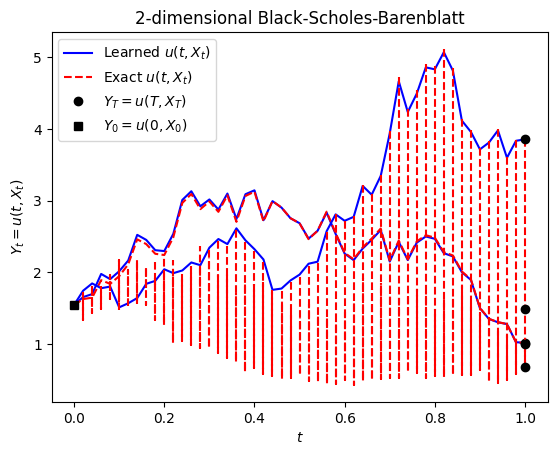

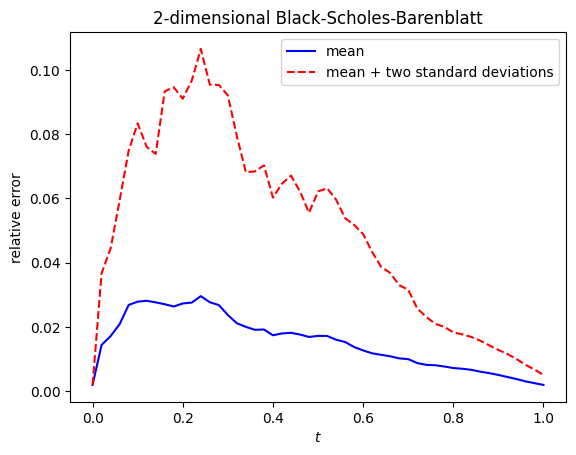

In [ ]:
Y_test = np.reshape(u_exact(np.reshape(t_test[0:M,:,:],[-1,1]), np.reshape(X_pred[0:M,:,:],[-1,D])),[M,-1,1])

samples = 5

plt.figure()
plt.plot(t_test[0:1,:,0][0],Y_pred[0:1,:,0].numpy()[0],'b',label='Learned $u(t,X_t)$')
plt.plot(t_test[0:1,:,0][0],Y_test[0:1,:,0][0],'r--',label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1,-1,0],Y_test[0:1,-1,0],'ko',label='$Y_T = u(T,X_T)$')

plt.plot(t_test[1:samples,:,0][0],Y_pred[1:samples,:,0].numpy()[0],'b')
plt.plot(t_test[1:samples,:,0],Y_test[1:samples,:,0],'r--')
plt.plot(t_test[1:samples,-1,0],Y_test[1:samples,-1,0],'ko')

plt.plot([0],Y_test[0,0,0],'ks',label='$Y_0 = u(0,X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title('{}-dimensional Black-Scholes-Barenblatt'.format(D))
plt.legend();


errors = np.sqrt((Y_test-Y_pred)**2/Y_test**2)
mean_errors = np.mean(errors,0)
std_errors = np.std(errors,0)

plt.figure()
plt.plot(t_test[0,:,0],mean_errors,'b',label='mean')
plt.plot(t_test[0,:,0],mean_errors+2*std_errors,'r--',label='mean + two standard deviations')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.title('{}-dimensional Black-Scholes-Barenblatt'.format(D))
plt.legend();